In [142]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.fft import fft, ifft, fftfreq

In [143]:
def load_csv_data(filename: str) -> np.ndarray:
    '''time, x, y, z, abs'''
    with open(filename) as f:
        return np.array(list(zip(*(el.split(',') for el in f.readlines()[1:])))).astype(float)

In [144]:
def clean(data: np.ndarray) -> np.ndarray:
    mask1 = data[0] > 3
    mask2 = data[0] < 27
    return data[:, mask1 * mask2]

In [148]:
rest = clean(load_csv_data('data/rest.csv'))
exc = clean(load_csv_data('data/excited.csv'))

In [150]:
def get_spectrum(time: np.ndarray, data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    assert len(time) == len(data)
    N = len(time) + 1
    sampling_rate = (time[-1] - time[0]) / N
    freqs = fftfreq(N, sampling_rate)[:N//2]
    spectrum = 2.0 / N * np.abs(fft(data)[:N//2])
    spectrum[0] = 0.0
    return freqs, spectrum

In [151]:
def get_freq_from_time(time: np.ndarray, data: np.ndarray, npoints: int) -> tuple[np.ndarray, np.ndarray]:
    N = len(time) + 1

    window_width = N // npoints
    new_times = []
    new_freqs = []
    for i in range(npoints):
        new_times.append(time[(i+1) * window_width])
        slice_ = slice(i * window_width, (i+1) * window_width)
        freqs_tmp, spectrum_tmp = get_spectrum(time[slice_], data[slice_])
        new_freqs.append(freqs_tmp[np.argmax(spectrum_tmp)])
    return new_times, new_freqs

In [152]:
freqs_rest, spectrum_rest = get_spectrum(rest[0], rest[-1])
freqs_rest_small, spectrum_rest_small = freqs_rest[:140], spectrum_rest[:140]

In [153]:
freqs_exc, spectrum_exc = get_spectrum(exc[0], exc[-1])
freqs_exc_small, spectrum_exc_small = freqs_exc[:140], spectrum_exc[:140]

bpm rest: 65.00593637190387
bpm exc 100.02371719455273


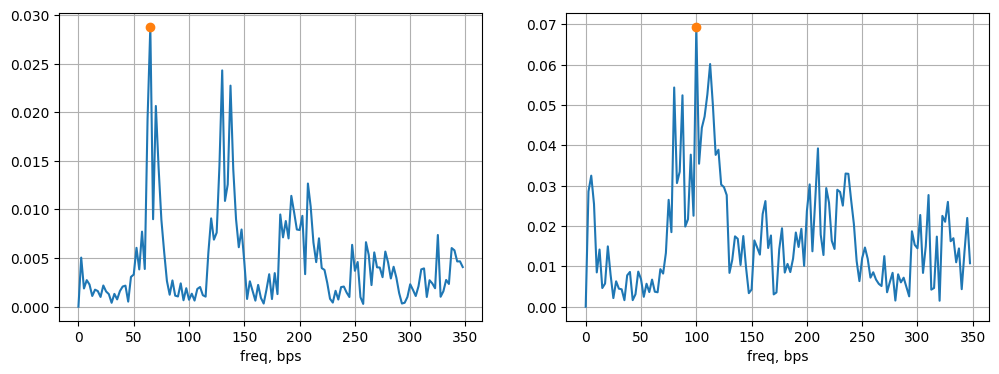

In [154]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(60 * freqs_rest_small, spectrum_rest_small)
axs[0].grid()
axs[0].set_xlabel('freq, bps')
max_index = np.argmax(spectrum_rest_small); bps_rest = freqs_rest_small[max_index]
print('bpm rest:', 60 * bps_rest)
axs[0].plot([60 * bps_rest], [spectrum_rest_small[max_index]], 'o')

axs[1].plot(60 * freqs_exc_small, spectrum_exc_small)
axs[1].grid()
axs[1].set_xlabel('freq, bps')
max_index = np.argmax(spectrum_exc_small); bps_exc = freqs_exc_small[max_index]
print('bpm exc', 60 * bps_exc)
axs[1].plot([60 * bps_exc], [spectrum_exc_small[max_index]], 'o')

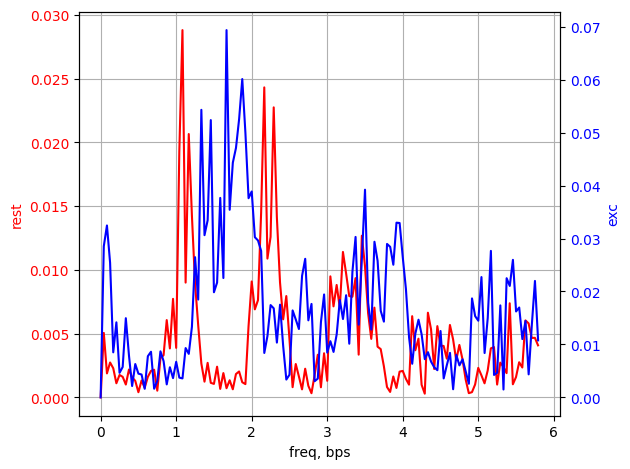

In [111]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('freq, bps')
ax1.set_ylabel('rest', color='red')
ax1.plot(freqs_rest_small, spectrum_rest_small, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('exc', color='blue')  # we already handled the x-label with ax1
ax2.plot(freqs_exc_small, spectrum_exc_small, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [86]:
def find_peaks(data, n_peaks: int, min_height=0.3):
    '''Finds peaks with an appropriate spacing'''
    peaks_ids, info = sci.signal.find_peaks(data, height=min_height)
    hs = info['peak_heights']
    delta_min = 0.7 * len(data) / n_peaks
    buffer = [(peaks_ids[0], hs[0])]
    res = []
    for p, h in zip(peaks_ids[1:], hs[1:]):
        if p - buffer[-1][0] > delta_min:
            res.append(
                max(buffer, key=lambda x: x[1])[0]
            )
            buffer = [(p, h)]
        else:
            buffer.append((p, h))
    res.append(buffer[0][0])
    return np.array(res)

In [87]:
def get_bps_graph(beat_times: np.ndarray):
    diffs = beat_times[1:] - beat_times[:-1]
    return diffs

In [115]:
# choose appropriate n_peaks so that most standalone heartbeats are recorded
peaks_ids_rest = find_peaks(rest[-1], n_peaks=45, min_height=0.3)
peaks_ids_exc = find_peaks(exc[-1], n_peaks=70, min_height=0.45)

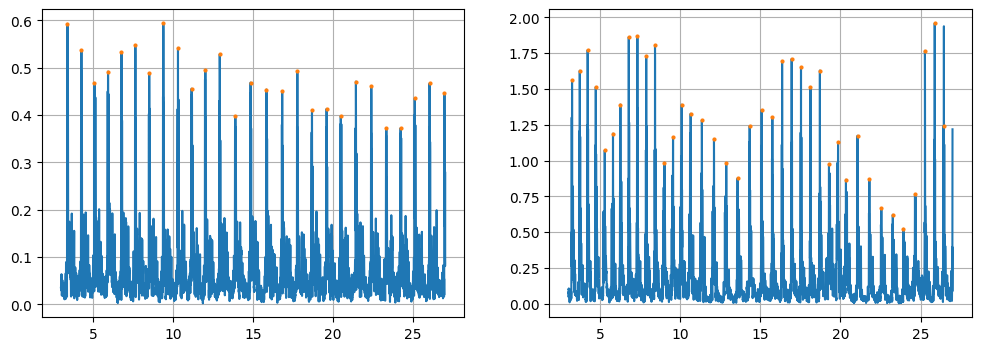

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(rest[0], rest[-1])
axs[0].plot(rest[0][peaks_ids_rest], rest[-1][peaks_ids_rest], 'o', ms=2)
axs[1].plot(exc[0], exc[-1])
axs[1].plot(exc[0][peaks_ids_exc], exc[-1][peaks_ids_exc], 'o', ms=2)
axs[0].grid(); axs[1].grid()
# fig.show()

In [109]:
standalone_beats_rest = rest[0][peaks_ids_rest]
diffs_rest = get_bps_graph(standalone_beats_rest)
standalone_beats_exc = exc[0][peaks_ids_exc]
diffs_exc = get_bps_graph(standalone_beats_exc)

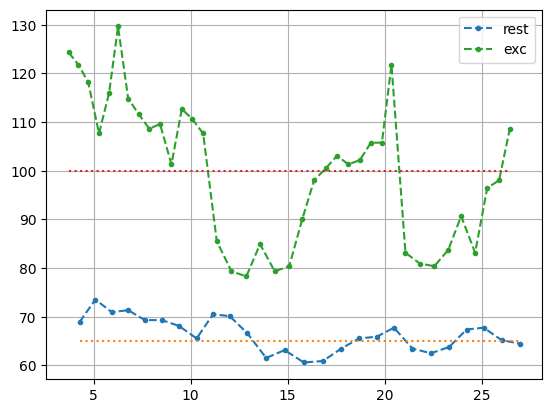

In [124]:
plt.plot(standalone_beats_rest[1:], 60./diffs_rest, '--o', ms=3, label='rest')
plt.plot(standalone_beats_rest[1:], 60 * bps_rest * np.ones((len(standalone_beats_rest)-1)), ':')
plt.plot(standalone_beats_exc[1:], 60./diffs_exc, '--o', ms=3, label='exc')
plt.plot(standalone_beats_exc[1:], 60 * bps_exc * np.ones((len(standalone_beats_exc)-1)), ':')
plt.legend()
plt.grid()